In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
ROOT_DATA_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data'
sys.path.append(ROOT_PACKAGE_DIRECTORY)

# Experiment Graph
from experiment_graph.execution_environment import ExecutionEnvironment as ee


# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline


try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [2]:
print(os.listdir(ROOT_DATA_DIRECTORY))
app_train = ee.load(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape().get())
app_train.head().get()

app_test = ee.load(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape().get())
app_test.head().get()

['home-credit-default-risk']


('Training data shape: ', (307511, 122))


('Testing data shape: ', (48744, 121))


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().get()

    mis_val_percent = 100 * mis_val / len(dataset.get())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data[1]) + " columns.\n"
                                                                          "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [4]:
app_train.meta['dtypes'].value_counts()

app_train.select_dtypes('object').nunique().get()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [2]:
ee.load_graph(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/graph.obj')

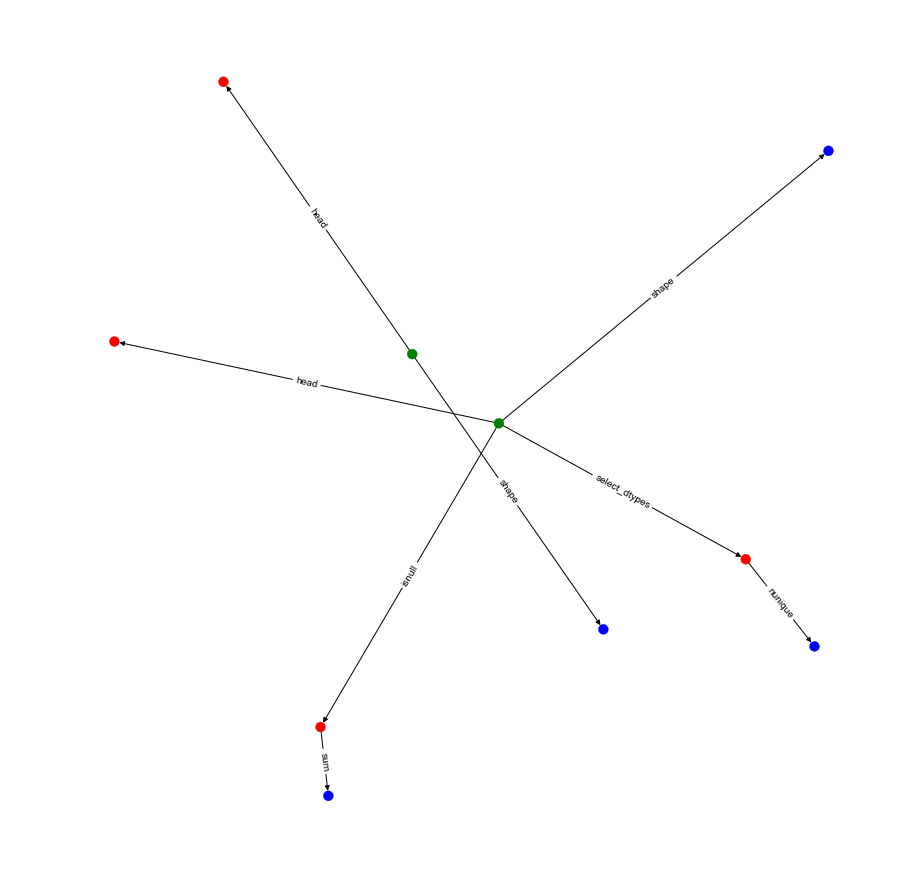

In [4]:
ee.graph.plot_graph(plt)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, Imputer

# Make the model with the specified regularization parameter
sk_imputer = Imputer(strategy = 'median')
sk_log_reg = LogisticRegression(C = 0.0001)
train = app_train[['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_ANNUITY','FLAG_DOCUMENT_18']]
test = app_test[['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_ANNUITY','FLAG_DOCUMENT_18']]
# Fit on the training data
imputer = train.fit_sk_model(sk_imputer)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

train_labels = app_train['TARGET']
# Train on the training data
log_reg = train.fit_sk_model_with_labels(sk_log_reg, train_labels)

In [ ]:
pred = log_reg.predict_proba(test)

In [ ]:
pred.get()[:]

In [5]:
temp = app_train['SK_ID_CURR'].concat(app_train['TARGET'])

In [12]:
temp = app_train.head(100)

In [15]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

for t, v in k_fold.split(temp.get()):
    print t
    print v

[ 0  1  2  4  5  6  7  9 10 11 12 13 14 19 20 21 22 23 24 26 27 28 29 30 31
 32 33 35 36 37 41 42 43 44 45 46 48 49 51 54 55 56 58 59 60 61 62 63 64 65
 66 67 68 70 71 72 73 74 75 76 77 78 81 82 83 84 85 86 88 89 90 91 92 93 94
 95 96 97 98 99]
[ 3  8 15 16 17 18 25 34 38 39 40 47 50 52 53 57 69 79 80 87]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19 20 22 24 25 26 27 28
 29 30 31 33 34 35 36 38 39 40 41 43 45 46 47 48 49 50 51 52 53 55 56 57 60
 61 63 64 65 66 67 68 69 70 71 73 74 75 77 78 79 80 81 83 84 85 87 88 89 92
 93 94 96 97 99]
[12 14 21 23 32 37 42 44 54 58 59 62 72 76 82 86 90 91 95 98]
[ 0  2  3  4  5  6  8 10 11 12 14 15 16 17 18 19 20 21 22 23 25 26 29 30 31
 32 33 34 35 37 38 39 40 41 42 43 44 47 48 49 50 51 52 53 54 57 58 59 60 62
 63 64 66 67 68 69 70 71 72 73 74 76 77 78 79 80 82 83 84 85 86 87 89 90 91
 93 94 95 96 98]
[ 1  7  9 13 24 27 28 36 45 46 55 56 61 65 75 81 88 92 97 99]
[ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26 27
 28

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = features.onehot_encode()
        test_features = test_features.onehot_encode()
        
        # Align the dataframes by the columns
        for c in features.get().columns:
            if c not in test_features.get().columns:
                features = features.drop(c)
                
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder object
        le = LabelEncoder()
        # List for storing categorical indices
        cat_indices = []

        for i, col in enumerate(features.select_dtypes('object').get().columns):
            # we are not using nunique because it discard nan
            label_encoder = features[col].fit_sk_model(le)

            transformed_feature = features.transform_col(features[col], col)
            features = features.drop(col)
            features = features.add_columns(transformed_feature, col)

            transformed_feature_test = model.transform_col(test_features[col], col)
            test_features = test_features.drop(col)
            test_features = test_features.add_columns(transformed_feature_test, col)
            cat_indices.append(i)    
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape().get())
    print('Testing Data Shape: ', test_features.shape().get())
    
    # Extract feature names
    feature_names = list(features.get().columns)


    # Create the model
    lgb_model = lgb.LGBMClassifier(n_estimators=10, objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, 
                               subsample = 0.8, n_jobs = -1, random_state = 50)
        
    model = features.fit_sk_model_with_labels(lgb_model, labels, custom_args={'eval_metric':'auc',
                                                                             'categorical_feature':cat_indices,
                                                                             'verbose':200})    
        
    # Record the best iteration
    best_iteration = model.get().best_iteration_
    
        
    # Make predictions
    test_predictions = model.predict_proba(test_features, custom_args={'num_iteration':best_iteration})[1] 
        
    
    test_predictions.setname('TARGET')
    # Make the submission dataframe
    submission = test_ids.concat(test_predictions)
    
    feature_importances = model.feature_importances(feature_names)
   

    return submission, feature_importances

In [10]:
s,f = model(app_train, app_test)

('Training Data Shape: ', (307511, 241))
('Testing Data Shape: ', (48744, 241))


In [13]:
f.get()

,feature,importance
0,CNT_CHILDREN,0
1,AMT_INCOME_TOTAL,0
2,AMT_CREDIT,2
3,AMT_ANNUITY,1
4,AMT_GOODS_PRICE,3
5,REGION_POPULATION_RELATIVE,0
6,DAYS_BIRTH,37
7,DAYS_EMPLOYED,8
8,DAYS_REGISTRATION,0
9,DAYS_ID_PUBLISH,0


In [ ]:
model = model.fit(app_train.get(),features['TARGET'].get(), )    